In [76]:
import cv2
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import LTBP as ltbp
import LBP as lbp
import hamming_distance as hd
from enum import Enum
import glob
import pandas as pd

def draw_partial_circle(mask, center, r, angle_start, angle_end, thickness=2):
    """
    Draws an arc (partial circle) on a mask from angle_start to angle_end.
    Angles are in degrees.
    """
    axes = (r, r)
    cv2.ellipse(mask, center, axes, 0, angle_start, angle_end, 255, thickness)

def daugman(gray_img: np.ndarray, center: tuple, start_r: int, end_r: int, step: int = 1,
            angle_start: int = 45, angle_end: int = 135, thickness: int = 3) -> tuple:
    """
    Improved Daugman operator using partial circles to avoid occluded regions.

    Parameters:
        gray_img: Grayscale eye image
        center: (x, y) tuple
        start_r: Start of radius range
        end_r: End of radius range
        step: Radius increment step
        angle_start: Start angle of arc (in degrees)
        angle_end: End angle of arc (in degrees)
        thickness: Thickness of arc

    Returns:
        max_response: maximum intensity gradient
        best_radius: radius corresponding to max_response
    """
    x, y = center
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    radii = list(range(start_r, end_r, step))
    intensities = []

    for r in radii:
        # Draw both top and bottom horizontal arcs (excluding eyelids)
        draw_partial_circle(mask, center, r, 0, 360, thickness)     # top/middle
        #draw_partial_circle(mask, center, r, 225, 300, thickness)    # bottom/middle
    
        diff = gray_img & mask
    
        if np.count_nonzero(diff) > 0:
            avg_intensity = np.sum(diff[diff > 0]) / np.count_nonzero(diff)
        else:
            avg_intensity = 0
    
        intensities.append(avg_intensity)
        mask.fill(0)

    # Compute gradient of intensities
    intensities_np = np.array(intensities, dtype=np.float32)
    gradient = intensities_np[:-1] - intensities_np[1:]
    gradient = cv2.GaussianBlur(np.abs(gradient), (1, 5), 0)

    # Find strongest gradient
    idx = np.argmax(gradient)
    return gradient[idx], radii[idx]

def enhance_iris_contrast(gray_img):
    """
    Enhance contrast between iris and sclera in a grayscale image.
    
    Parameters:
    - gray_img: Grayscale image (NumPy array)
    
    Returns:
    - enhanced_gray: Contrast-enhanced grayscale image
    """
    # Step 1: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray_img)
    
    # Step 2: High-pass filtering (sharpens edges)
    blurred = cv2.GaussianBlur(gray_clahe, (9, 9), 0)
    high_pass = cv2.subtract(gray_clahe, blurred)
    
    # Final result is grayscale
    enhanced_gray = gray_clahe
    
    return enhanced_gray

def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 4) -> Tuple[Tuple[int, int], int]:

    h, w = gray.shape
    if h != w:
        print('Warning: image is not square!')

    axis_range = range(h // 3, 2 * h // 3, points_step) #range(h // 3, 2 * h // 3, points_step)
    all_points = itertools.product(axis_range, axis_range)

    intensity_values = []
    coords = []

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    best_idx = np.argmax(intensity_values)
    return coords[best_idx]

def crop_image_square(image):
    """
    Crops an OpenCV image (NumPy array) to a square shape.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x C) or (H x W)
    
    Returns:
    - square_cropped: Cropped square image
    """
    height, width = image.shape[:2]
    min_dim = min(height, width)
    
    # Compute cropping coordinates
    top = (height - min_dim) // 2
    bottom = top + min_dim
    left = (width - min_dim) // 2
    right = left + min_dim
    
    # Crop using slicing
    square_cropped = image[top:bottom, left:right]
    return square_cropped

def draw_pizza_slice_arcs(image, center, radius, thickness=5):
    """
    Overlay 45–135° and 225–315° arcs on the image.
    """
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.ellipse(mask, center, (radius, radius), 0, 45, 135, 255, thickness)
    cv2.ellipse(mask, center, (radius, radius), 0, 225, 315, 255, thickness)

    overlay = image.copy()
    overlay[mask == 255] = 255  # brighten arc regions
    return overlay


def segment_iris_and_pupil(image_path: str):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Couldn't load image: {image_path}")
    gray = crop_image_square(gray)
    h, w = gray.shape
    #if h > 480:
    #    gray = cv2.resize(gray, (480, 480))  # Make square
    
    
    pupil_center, pupil_r = find_iris(gray, daugman_start=int(h/10), daugman_end= int(h/6), points_step=4)

    gray_enhanced = enhance_iris_contrast(gray)

    iris_center, iris_r = find_iris(gray_enhanced, daugman_start=pupil_r + 15, daugman_end=pupil_r*4, points_step=4)

    output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.circle(output, pupil_center, pupil_r, (255, 0, 0), 1)
    cv2.circle(output, iris_center, iris_r, (0, 255, 0), 1)

    # Add arc visualization on grayscale for clarity
    arc_overlay = draw_pizza_slice_arcs(gray, iris_center, iris_r, thickness=2)
    """
    plt.imshow(output[..., ::-1])
    plt.title("Iris and Pupil Detection (Daugman)")
    plt.axis('off')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(arc_overlay, cmap='gray')
    plt.title("Iris Sampling Arcs (45°–135°, 225°–315°)")
    plt.axis('off')
    plt.show()

    plt.imshow(gray_enhanced, cmap='gray')
    """
    return pupil_center, pupil_r, iris_center, iris_r, gray


In [77]:
def show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r):
     # Display the original and normalized iris
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.scatter(*pupil_center, color='red', marker='x', label='Pupil Center')
    plt.scatter(*iris_center, color='blue', marker='x', label='Iris Center')
    circle1 = plt.Circle(pupil_center, pupil_r, color='red', fill=False)
    circle2 = plt.Circle(iris_center, iris_r, color='blue', fill=False)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Normalized Iris')
    plt.imshow(normalized_iris, cmap='gray')
    plt.xlabel('Theta (angle)')
    plt.ylabel('Radius (normalized)')
    plt.show()

def show_iris_code(iris_code):
    plt.imshow(iris_code, cmap='gray')
    plt.show()
    

In [78]:
def normalize_iris(image, pupil_center, pupil_radius, iris_center, iris_radius, n_theta=720, n_r=128):
    # Step 1: Generate theta and r
    theta = np.linspace(0, 2 * np.pi, n_theta)
    r = np.linspace(0, 1, n_r)
    
    # Step 2: Generate boundary coordinates
    xp = pupil_center[0] + pupil_radius * np.cos(theta)
    yp = pupil_center[1] + pupil_radius * np.sin(theta)
    
    xi = iris_center[0] + iris_radius * np.cos(theta)
    yi = iris_center[1] + iris_radius * np.sin(theta)
    
    # Step 3: Generate grid of sampling points
    theta_grid, r_grid = np.meshgrid(theta, r)
    
    xp_grid = xp[np.newaxis, :]
    yp_grid = yp[np.newaxis, :]
    xi_grid = xi[np.newaxis, :]
    yi_grid = yi[np.newaxis, :]
    
    x_norm = (1 - r_grid) * xp_grid + r_grid * xi_grid
    y_norm = (1 - r_grid) * yp_grid + r_grid * yi_grid
    
    # Step 4: Sample the image using map_coordinates
    coords = [y_norm.flatten(), x_norm.flatten()]  # Note: (row, col) = (y, x)
    normalized = map_coordinates(image, coords, order=1, mode='reflect')
    normalized = normalized.reshape((n_r, n_theta))
    
    return normalized




In [ ]:
def apply_gabor_filter(image, ksize=31, sigma=4.0, theta=0.0, lambd=10.0, gamma=0.5, psi=0):
    """
    Applies a Gabor filter to a grayscale image.

    Parameters:
    - image: Input grayscale image (NumPy array)
    - ksize: Size of the filter kernel (must be odd)
    - sigma: Standard deviation of the Gaussian envelope
    - theta: Orientation of the normal to the parallel stripes (in radians)
    - lambd: Wavelength of the sinusoidal factor
    - gamma: Spatial aspect ratio (ellipticity)
    - psi: Phase offset

    Returns:
    - filtered: Image after applying Gabor filter (float32)
    """
    # Create Gabor kernel
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

    # Apply filter
    filtered = cv2.filter2D(image.astype(np.float32), cv2.CV_32F, kernel)

    return filtered

def generate_gabor_mask(gabor_response):
    """
    Create a binary mask from Gabor response.
    1 = valid (strong texture), 0 = weak (likely occlusion or noise)
    """
    low_threshold=550
    high_threshold = 2300
    magnitude = np.abs(gabor_response)
    low_mask = (magnitude > low_threshold).astype(np.uint8)
    high_mask = (magnitude < high_threshold ).astype(np.uint8)
    mask = low_mask & high_mask
    
    plt.imshow(mask)
    plt.title("Mask of gabor response")
    plt.show()
    
    return mask




In [80]:
def pipeline(img_path, method : hd.binary_method):
    # Create empty iris code array
    iris_code = np.array([])
    
    pupil_center, pupil_r, iris_center, iris_r, image = segment_iris_and_pupil(img_path)
    #print(pupil_center, pupil_r, iris_center, iris_r)
    
    normalized_iris = normalize_iris(image, pupil_center, pupil_r, iris_center, iris_r)
    show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r)

    if method is hd.binary_method.LTBP_ZERO:
        iris_code = ltbp.LTBP_loop_pixels(normalized_iris, ltbp.LTBP_method.ZERO)
    elif method is hd.binary_method.LTBP_MIRROR:
        iris_code = ltbp.LTBP_loop_pixels(normalized_iris, ltbp.LTBP_method.MIRROR)
    elif method is hd.binary_method.LTBP_ORIGINAL:
        iris_code = ltbp.LTBP_loop_pixels(normalized_iris, ltbp.LTBP_method.ORIGINAL)
    elif method is hd.binary_method.LBP:
        iris_code = lbp.LBP_loop_pixels(normalized_iris)
    
    else:
        raise ValueError("Incorrect method supplied for the binary pattern generation")
    
    #generate mask
    gabor_response = apply_gabor_filter(normalized_iris)
    mask1 = generate_gabor_mask(gabor_response)
    
    # Show gabor response data
    plt.imshow(np.abs(gabor_response), cmap='hot')
    plt.title("Gabor Magnitude")
    plt.colorbar()
    plt.show()
    
    gabor_response = apply_gabor_filter(normalized_iris, theta=math.pi/2)
    mask2 = generate_gabor_mask(gabor_response)
    
    # Show gabor response data
    plt.imshow(np.abs(gabor_response), cmap='hot')
    plt.title("Gabor Magnitude")
    plt.colorbar()
    plt.show()
    
    mask_combined = mask1 & mask2
    mask = cv2.resize(mask_combined, (iris_code.shape[1], iris_code.shape[0])) #make mask same size as iris code

    # plt.imshow(mask)
    # plt.title("Combined masks of both gabor responses")
    # plt.show()

    return iris_code, mask


In [81]:
# Generates list of all file paths in the folder
image_path_array = glob.glob("Iris_Pictures/*.jpg") 

# Size values for the normalized iris
normalized_height = 128
normalized_width = 720
ltbp_normalized_height = normalized_height*2
ltbp_normalized_width = normalized_width*2

Code part for calculating hamming distances using LBP

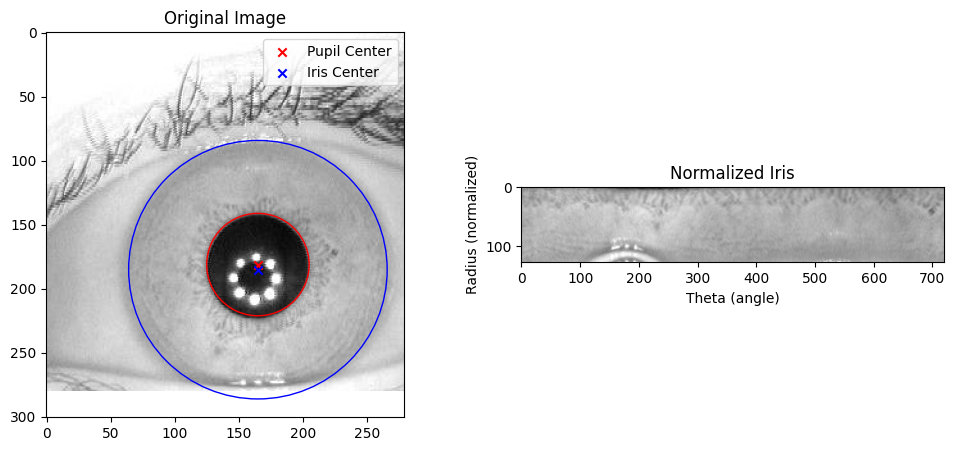

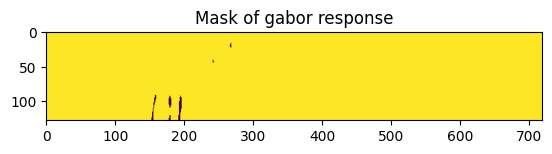

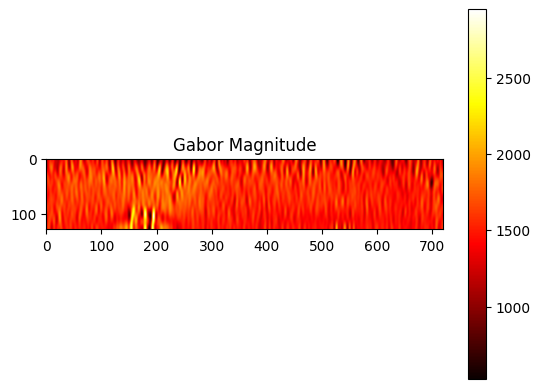

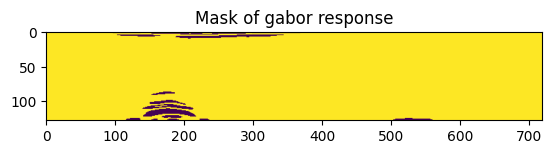

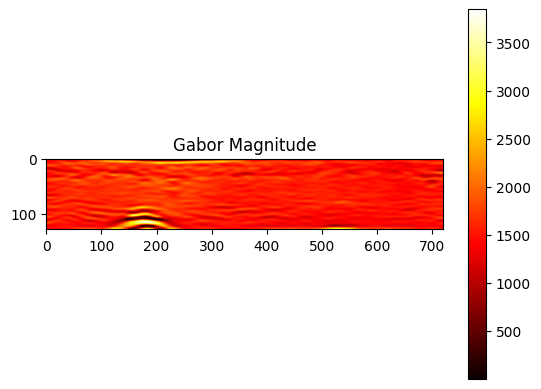

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = bool is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [82]:
# Creates empty array to store values in
LBP_iris_code_array = np.empty((0, normalized_height, normalized_width), dtype=np.uint8)
LBP_mask_array = np.empty((0, normalized_height, normalized_width), dtype=np.uint8)

# Loops through all images and calculates using LBP
for i in range(len(image_path_array)):
    code, mask = pipeline(image_path_array[i], hd.binary_method.LBP)

    # Add new dimension for higher-dimension concatenation
    code = code[np.newaxis, ...]
    mask = mask[np.newaxis, ...]
    
    # Concatenate new values into the existing array along the 1st dimension (single sized)
    LBP_iris_code_array = np.concatenate((LBP_iris_code_array, code), axis=0)
    LBP_mask_array = np.concatenate((LBP_mask_array, mask), axis=0)

# Declaring variables to be used in loop
LBP_hd_unmasked = np.array([])
LBP_hd_masked = np.array([])

type_of_comparison = np.array([])
type_comparison_iterator = 0

# Loops through path list and generates hamming distances for all the LBP-codes
for i in range(len(LBP_iris_code_array)):
    for j in range(i+1, len(LBP_iris_code_array)):
        # Generate the string that will tell whether it was the same person or not
        # Array used in the preceding methods as well
        if image_path_array[i][15:19] == image_path_array[j][15:19]:
            type_of_comparison = np.append(type_of_comparison, "Same person")
        else:
            type_of_comparison = np.append(type_of_comparison, "Different person")
        
        ham_dist = hd.hamming_distance_no_mask(LBP_iris_code_array[i], LBP_iris_code_array[j], hd.binary_method.LBP)
        LBP_hd_unmasked = np.append(LBP_hd_unmasked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LBP Hamming Distance between {i} and {j} (without mask): {ham_dist}")
        
        ham_dist = hd.hamming_distance(LBP_iris_code_array[i], LBP_mask_array[i], LBP_iris_code_array[j], LBP_mask_array[j], hd.binary_method.LBP)
        LBP_hd_masked = np.append(LBP_hd_masked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LBP Hamming Distance between {i} and {j} (with mask): {ham_dist}")
        type_comparison_iterator += 1   

# Converts all the data into a pandas dataframe for data processing
LBP_df = pd.DataFrame({
    "Hamming distance unmasked": LBP_hd_unmasked,
    "Hamming distance masked": LBP_hd_masked,
    "Comparison type": type_of_comparison
})

# Calculates difference between masked and unmasked 
LBP_df["Masked difference"] = LBP_df["Hamming distance masked"].sub(LBP_df["Hamming distance unmasked"], axis=0)
print(f"Mean difference between masked and unmasked: {LBP_df["Masked difference"].mean()}")

# Calculates mean and deviation unmasked values for different person
print(f"Mean unmasked values for different person: {LBP_df.loc[LBP_df["Comparison type"] == "Different person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for different person: {LBP_df.loc[LBP_df["Comparison type"] == "Different person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation unmasked values for same person  
print(f"Mean unmasked values for same person: {LBP_df.loc[LBP_df["Comparison type"] == "Same person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for same person: {LBP_df.loc[LBP_df["Comparison type"] == "Same person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation masked values for different person 
print(f"Mean masked values for different person: {LBP_df.loc[LBP_df["Comparison type"] == "Different person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for different person: {LBP_df.loc[LBP_df["Comparison type"] == "Different person", "Hamming distance masked"].std()}")

# Calculates mean and deviation masked values for same person
print(f"Mean masked values for same person: {LBP_df.loc[LBP_df["Comparison type"] == "Same person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for same person: {LBP_df.loc[LBP_df["Comparison type"] == "Same person", "Hamming distance masked"].std()}")

In [ ]:

# Creates empty array to store values in
LTBP_O_iris_code_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)
LTBP_O_mask_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)

# Loops through all images and calculates using LTBP zero method
for i in range(len(image_path_array)):
    code, mask = pipeline(image_path_array[i], hd.binary_method.LTBP_ORIGINAL)

    # Add new dimension for higher-dimension concatenation
    code = code[np.newaxis, ...]
    mask = mask[np.newaxis, ...]
    
    # Concatenate new values into the existing array along the 1st dimension (single sized)
    LTBP_O_iris_code_array = np.concatenate((LTBP_O_iris_code_array, code), axis=0)
    LTBP_O_mask_array = np.concatenate((LTBP_O_mask_array, mask), axis=0)

# Declaring variables to be used in loop
LTBP_O_hd_unmasked = np.array([])
LTBP_O_hd_masked = np.array([])

type_comparison_iterator = 0

# Loops through path list and generates hamming distances for all the zeroed LTBP-codes
for i in range(len(LTBP_O_iris_code_array)):
    for j in range(i+1, len(LTBP_O_iris_code_array)):
        ham_dist = hd.hamming_distance_no_mask(LTBP_O_iris_code_array[i], LTBP_O_iris_code_array[j], hd.binary_method.LTBP_ORIGINAL)
        LTBP_O_hd_unmasked = np.append(LTBP_O_hd_unmasked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (without mask, zeroing method): {ham_dist}")

        ham_dist = hd.hamming_distance(LTBP_O_iris_code_array[i], LTBP_O_mask_array[i], LTBP_O_iris_code_array[j], LTBP_O_mask_array[j], hd.binary_method.LTBP_ORIGINAL)
        LTBP_O_hd_masked = np.append(LTBP_O_hd_masked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (with mask, zeroing method): {ham_dist}")
        type_comparison_iterator += 1
        
# Converts all the data into a pandas dataframe for data processing
LTBP_O_df = pd.DataFrame({
    "Hamming distance unmasked": LTBP_O_hd_unmasked,
    "Hamming distance masked": LTBP_O_hd_masked,
    "Comparison type": type_of_comparison
})

# Calculates difference between masked and unmasked 
LTBP_O_df["Masked difference"] = LTBP_O_df["Hamming distance masked"].sub(LTBP_O_df["Hamming distance unmasked"], axis=0)
print(f"Mean difference between masked and unmasked: {LTBP_O_df["Masked difference"].mean()}")

# Calculates mean and deviation unmasked values for different person
print(f"Mean unmasked values for different person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Different person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for different person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Different person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation unmasked values for same person  
print(f"Mean unmasked values for same person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Same person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for same person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Same person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation masked values for different person 
print(f"Mean masked values for different person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Different person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for different person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Different person", "Hamming distance masked"].std()}")

# Calculates mean and deviation masked values for same person
print(f"Mean masked values for same person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Same person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for same person: {LTBP_O_df.loc[LTBP_O_df["Comparison type"] == "Same person", "Hamming distance masked"].std()}")

KeyboardInterrupt: 

Code part for calculating hamming distances using LTBP with edge zeroing method

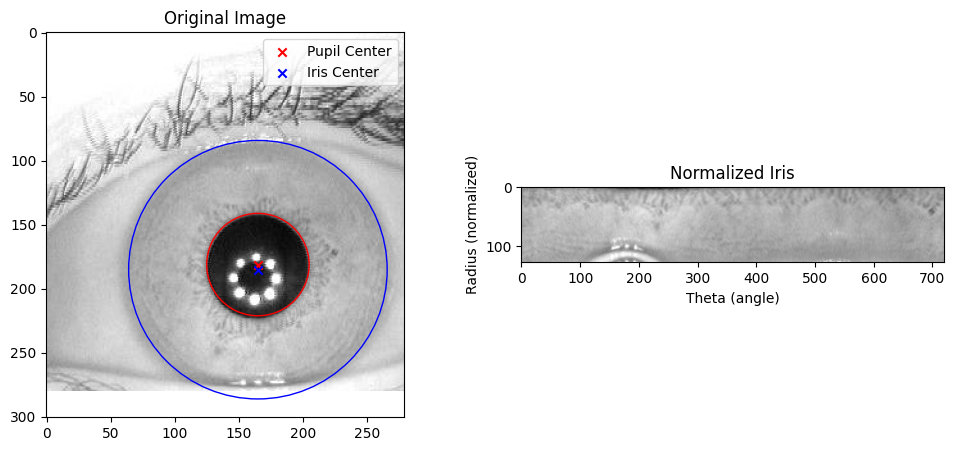

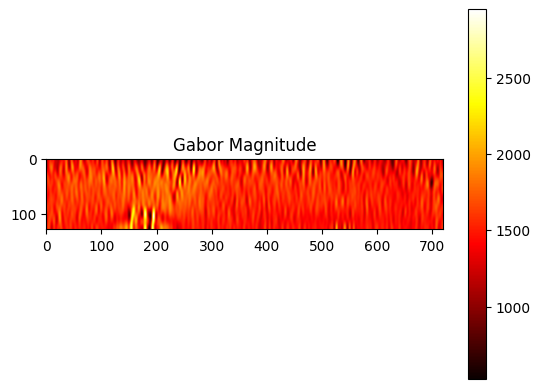

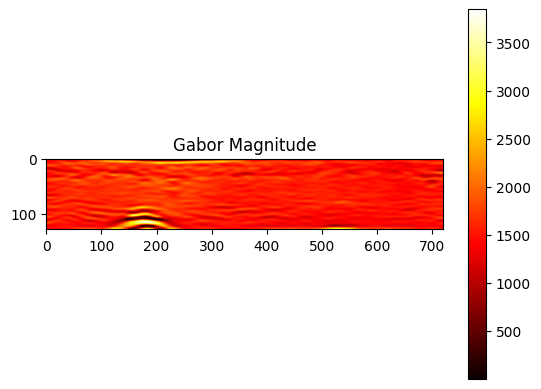

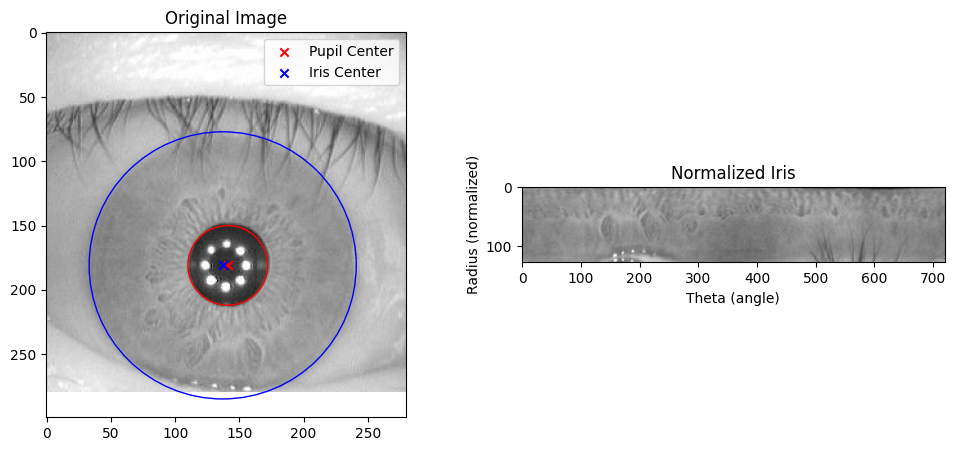

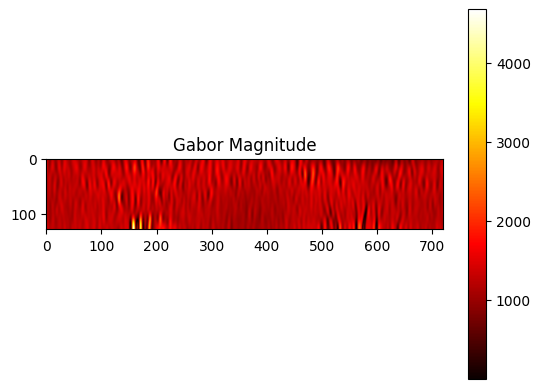

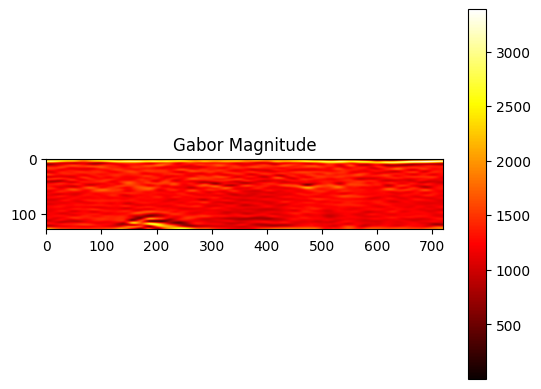

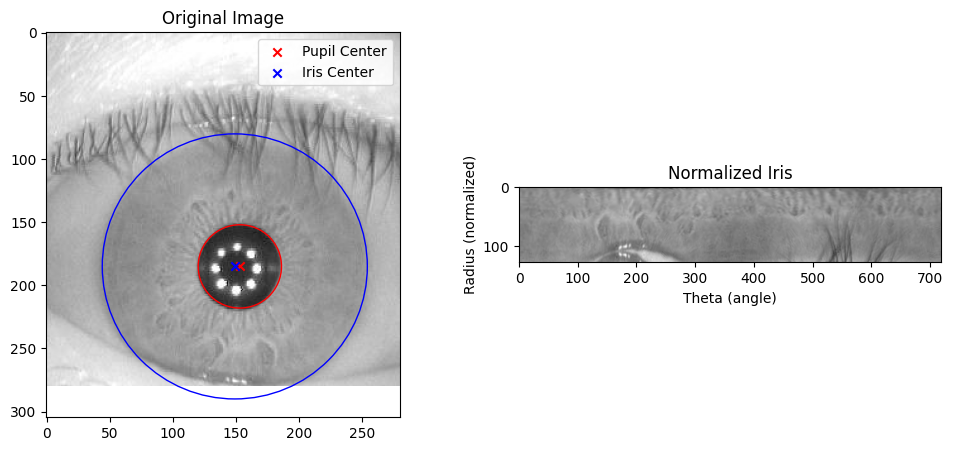

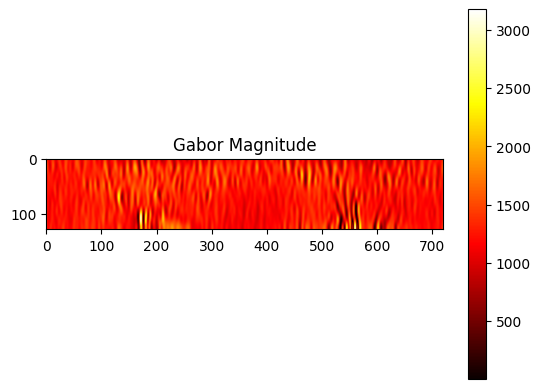

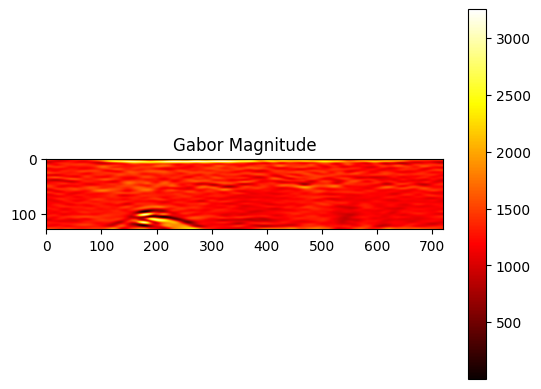

Mean difference between masked and unmasked: -0.000244464321210706
Mean unmasked values for different person: 0.46489257812499996
Standard deviation unmasked values for different person: 0.0011240358446596163
Mean unmasked values for same person: 0.4119805230034722
Standard deviation unmasked values for same person: nan
Mean masked values for different person: 0.46857338856551
Standard deviation masked values for different person: 0.0006834827081733235
Mean masked values for same person: 0.40388550915882
Standard deviation masked values for same person: nan


In [ ]:
# Creates empty array to store values in
LTBP_Z_iris_code_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)
LTBP_Z_mask_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)

# Loops through all images and calculates using LTBP zero method
for i in range(len(image_path_array)):
    code, mask = pipeline(image_path_array[i], hd.binary_method.LTBP_ZERO)

    # Add new dimension for higher-dimension concatenation
    code = code[np.newaxis, ...]
    mask = mask[np.newaxis, ...]
    
    # Concatenate new values into the existing array along the 1st dimension (single sized)
    LTBP_Z_iris_code_array = np.concatenate((LTBP_Z_iris_code_array, code), axis=0)
    LTBP_Z_mask_array = np.concatenate((LTBP_Z_mask_array, mask), axis=0)

# Declaring variables to be used in loop
LTBP_Z_hd_unmasked = np.array([])
LTBP_Z_hd_masked = np.array([])

type_comparison_iterator = 0

# Loops through path list and generates hamming distances for all the zeroed LTBP-codes
for i in range(len(LTBP_Z_iris_code_array)):
    for j in range(i+1, len(LTBP_Z_iris_code_array)):
        ham_dist = hd.hamming_distance_no_mask(LTBP_Z_iris_code_array[i], LTBP_Z_iris_code_array[j], hd.binary_method.LTBP_ZERO)
        LTBP_Z_hd_unmasked = np.append(LTBP_Z_hd_unmasked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (without mask, zeroing method): {ham_dist}")

        ham_dist = hd.hamming_distance(LTBP_Z_iris_code_array[i], LTBP_Z_mask_array[i], LTBP_Z_iris_code_array[j], LTBP_Z_mask_array[j], hd.binary_method.LTBP_ZERO)
        LTBP_Z_hd_masked = np.append(LTBP_Z_hd_masked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (with mask, zeroing method): {ham_dist}")
        type_comparison_iterator += 1
        
# Converts all the data into a pandas dataframe for data processing
LTBP_Z_df = pd.DataFrame({
    "Hamming distance unmasked": LTBP_Z_hd_unmasked,
    "Hamming distance masked": LTBP_Z_hd_masked,
    "Comparison type": type_of_comparison
})

# Calculates difference between masked and unmasked 
LTBP_Z_df["Masked difference"] = LTBP_Z_df["Hamming distance masked"].sub(LTBP_Z_df["Hamming distance unmasked"], axis=0)
print(f"Mean difference between masked and unmasked: {LTBP_Z_df["Masked difference"].mean()}")

# Calculates mean and deviation unmasked values for different person
print(f"Mean unmasked values for different person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Different person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for different person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Different person", "Hamming distance unmasked"].std()}")

# Calculates mean unmasked and deviation values for same person  
print(f"Mean unmasked values for same person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Same person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for same person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Same person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation masked values for different person 
print(f"Mean masked values for different person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Different person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for different person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Different person", "Hamming distance masked"].std()}")

# Calculates mean and deviation masked values for same person
print(f"Mean masked values for same person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Same person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for same person: {LTBP_Z_df.loc[LTBP_Z_df["Comparison type"] == "Same person", "Hamming distance masked"].std()}")

Code part for calculating hamming distances using LTBP with edge mirroring method

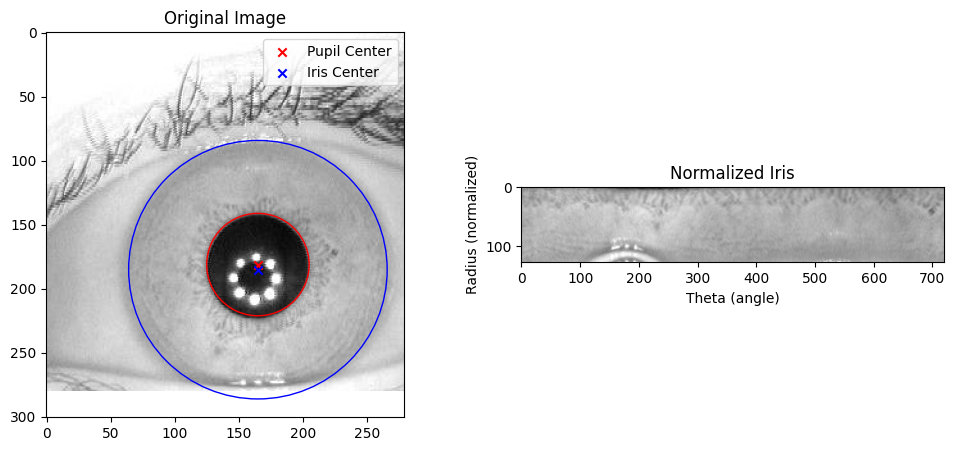

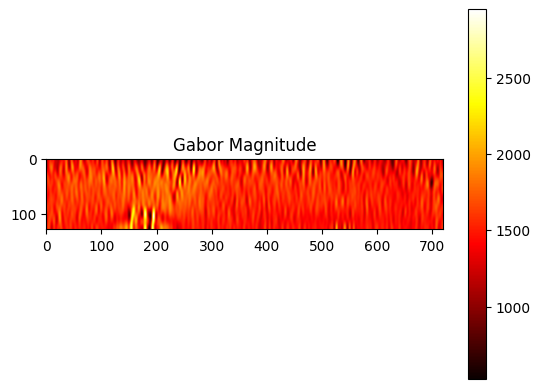

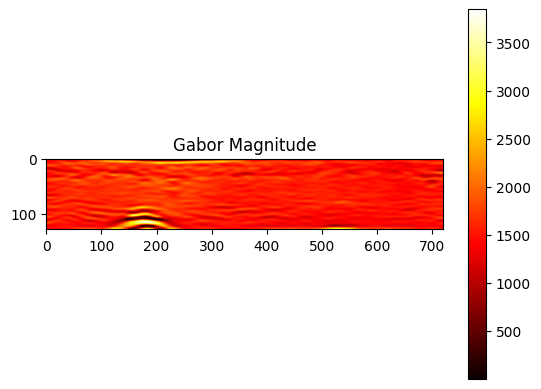

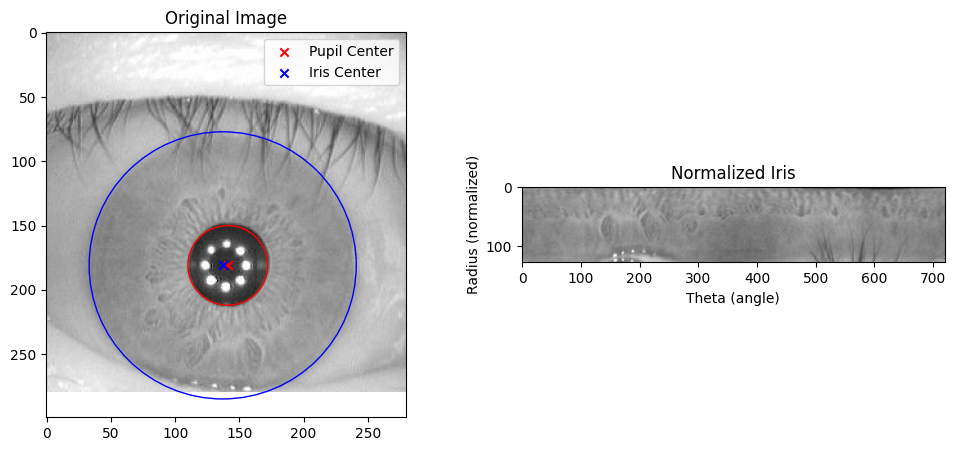

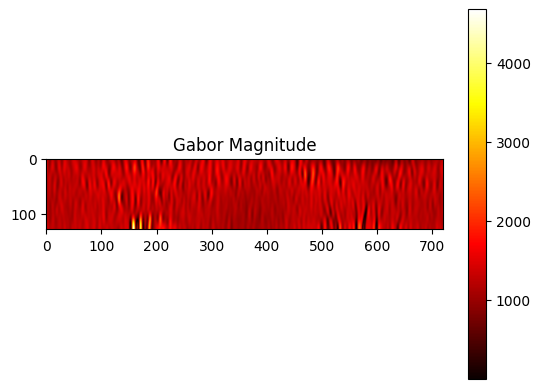

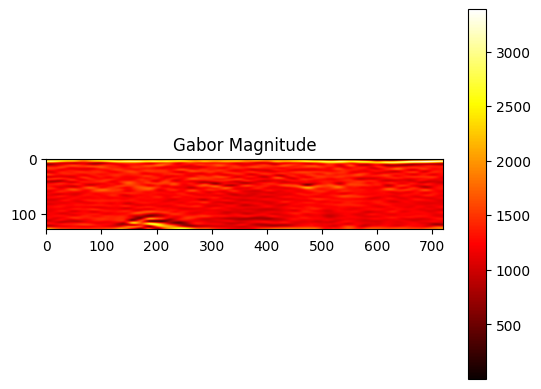

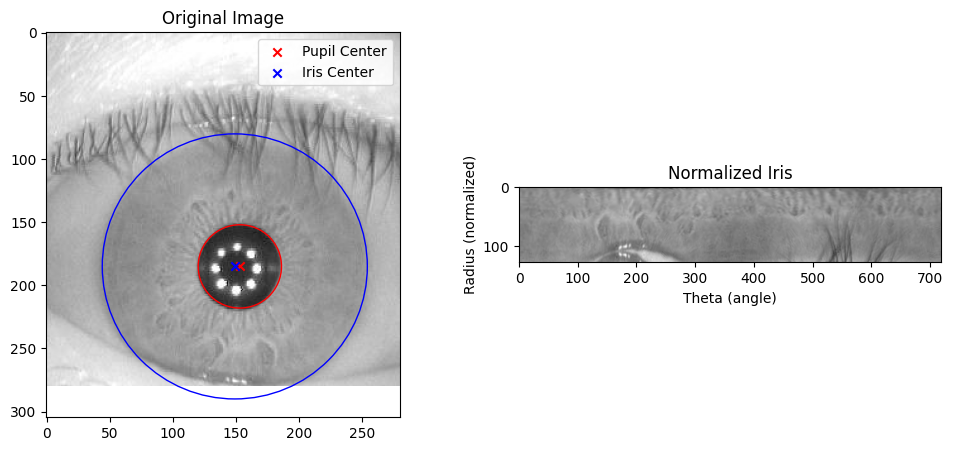

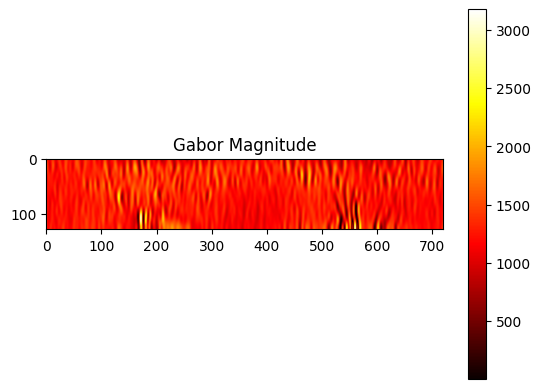

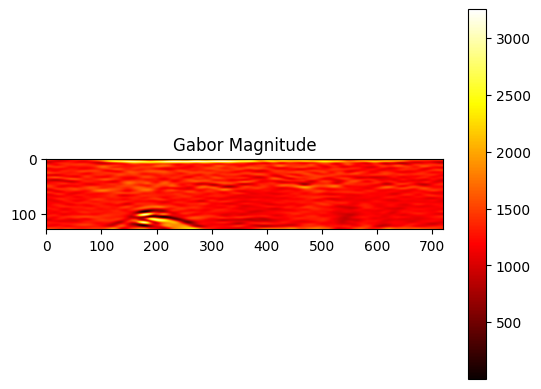

Mean difference between masked and unmasked: 0.0010210368830715355
Mean unmasked values for different person: 0.4674116346571181
Standard deviation unmasked values for different person: 0.001324482509790882
Mean unmasked values for same person: 0.4143012152777778
Standard deviation unmasked values for same person: nan
Mean masked values for different person: 0.47242188243195826
Standard deviation masked values for different person: 0.0010593023773411612
Mean masked values for same person: 0.4073438303773121
Standard deviation masked values for same person: nan


In [ ]:
# Creates empty array to store values in
LTBP_M_iris_code_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)
LTBP_M_mask_array = np.empty((0, ltbp_normalized_height, ltbp_normalized_width), dtype=np.uint8)

# Loops through all images and calculates using LTBP mirror method
for i in range(len(image_path_array)):
    code, mask = pipeline(image_path_array[i], hd.binary_method.LTBP_MIRROR)

    # Add new dimension for higher-dimension concatenation
    code = code[np.newaxis, ...]
    mask = mask[np.newaxis, ...]
    
    # Concatenate new values into the existing array along the 1st dimension (single sized)
    LTBP_M_iris_code_array = np.concatenate((LTBP_M_iris_code_array, code), axis=0)
    LTBP_M_mask_array = np.concatenate((LTBP_M_mask_array, mask), axis=0)

# Declaring variables to be used in loop
LTBP_M_hd_unmasked = np.array([])
LTBP_M_hd_masked = np.array([])

type_comparison_iterator = 0

# Loops through path list and generates hamming distances for all the mirrored LTBP-codes
for i in range(len(LTBP_M_iris_code_array)):
    for j in range(i+1, len(LTBP_M_iris_code_array)):
        ham_dist = hd.hamming_distance_no_mask(LTBP_M_iris_code_array[i], LTBP_M_iris_code_array[j], hd.binary_method.LTBP_MIRROR)
        LTBP_M_hd_unmasked = np.append(LTBP_M_hd_unmasked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (without mask, mirroring method): {ham_dist}")
        
        ham_dist = hd.hamming_distance(LTBP_M_iris_code_array[i], LTBP_M_mask_array[i], LTBP_M_iris_code_array[j], LTBP_M_mask_array[j], hd.binary_method.LTBP_MIRROR)
        LTBP_M_hd_masked = np.append(LTBP_M_hd_masked, ham_dist)
        
        # print(f"Type of check: {type_of_comparison[type_comparison_iterator]}")
        # print(f"LTBP Hamming Distance between {i} and {j} (with mask, mirroring method): {ham_dist}")
        type_comparison_iterator += 1
        
# Converts all the data into a pandas dataframe for data processing
LTBP_M_df = pd.DataFrame({
    "Hamming distance unmasked": LTBP_M_hd_unmasked,
    "Hamming distance masked": LTBP_M_hd_masked,
    "Comparison type": type_of_comparison
})

# Calculates difference between masked and unmasked 
LTBP_M_df["Masked difference"] = LTBP_M_df["Hamming distance masked"].sub(LTBP_M_df["Hamming distance unmasked"], axis=0)
print(f"Mean difference between masked and unmasked: {LTBP_M_df["Masked difference"].mean()}")

# Calculates mean and deviation unmasked values for different person
print(f"Mean unmasked values for different person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Different person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for different person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Different person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation unmasked values for same person  
print(f"Mean unmasked values for same person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Same person", "Hamming distance unmasked"].mean()}")
print(f"Standard deviation unmasked values for same person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Same person", "Hamming distance unmasked"].std()}")

# Calculates mean and deviation masked values for different person 
print(f"Mean masked values for different person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Different person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for different person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Different person", "Hamming distance masked"].std()}")

# Calculates mean and deviation masked values for same person
print(f"Mean masked values for same person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Same person", "Hamming distance masked"].mean()}")
print(f"Standard deviation masked values for same person: {LTBP_M_df.loc[LTBP_M_df["Comparison type"] == "Same person", "Hamming distance masked"].std()}")


Code part for showing the iris codes and their respective masks based on Gabor filters

In [ ]:
#show_iris_code(iris_code1)
#show_iris_code(mask1)
#print ("Iris code and mask 1:")

# show_iris_code(iris_code2)
# show_iris_code(mask2)
# print ("Iris code and mask 2:")

# show_iris_code(iris_code3)
# show_iris_code(mask3)
# print ("Iris code and mask 3:")


# Displays the combined masks
#combined_mask = mask1 & mask2
#show_iris_code(combined_mask)